# Implementando uma LSTM com Grid Search para escolher melhor os parâmetros no sistema de Mackey-Glass

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 125

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

import sys 
sys.path.insert(0, '../../../scripts')

### 1.2 Bibliotecas para LSTM

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

from tensorflow import keras

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit # para gridsearch com holdout

# o holdout são os últimos valores do vetor de dados de treino
# a cada divisão do timeseriessplit, o conjunto de treino incorpora mais dados do conjunto de teste

In [4]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [5]:
import lstm_model as lstm

### 1.3 Bibliotecas dos sistemas caóticos

In [8]:
import timeseries as times
import mackeyglassequations as mgeq

## 2. Gerando a série temporal

In [9]:
t_inicial = 0
t_final = 5000
tau = 22
n = 10
gamma = 0.1
beta = 0.2
theta = 1

In [10]:
macglass = mgeq.MackeyGlass(tau=tau, gamma=gamma, beta=beta, n=n, theta=theta)

In [11]:
solucoes, instantes_temporais = macglass.calcular(t_inicial = t_inicial, t_final = t_final)

Generating, compiling, and loading C code.
Using default integration parameters.


### Série Temporal de Mackey-Glass

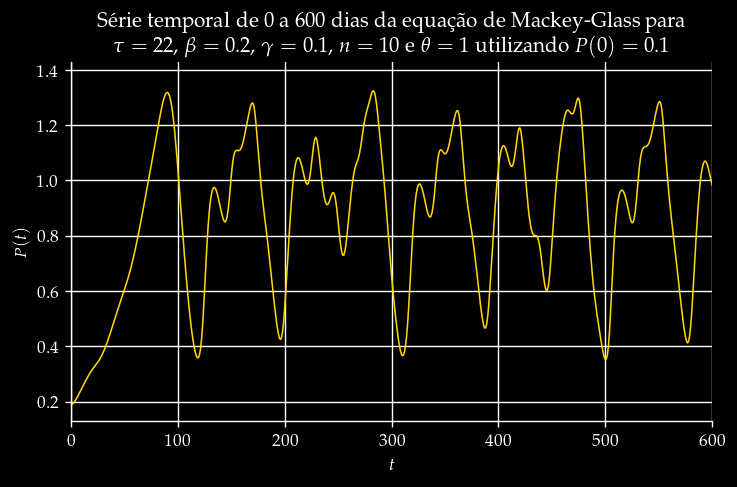

In [13]:
fig, ax = plt.subplots()
ax.set_title('Série temporal de 0 a 600 dias da equação de Mackey-Glass para\n' + r'$\tau =$ ' + str(tau) + r', $\beta =$ ' + str(beta) + r', $\gamma =$ ' + str(gamma) + r', $n =$ ' + str(n) + r' e $\theta =$ ' + str(theta) + ' utilizando $P(0) =$ ' + str(0.1*theta))
ax.plot(instantes_temporais, solucoes, color='Gold', linewidth=0.9)

ax.set_ylabel('$P(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(0,600)
    
ax.grid(True)

fig.tight_layout()
sns.despine()
plt.show()

In [20]:
x = np.array(solucoes)
x = np.reshape(x, (1, len(x)))
x = x[0]

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [21]:
K = 4
L = 3
tam_teste = 0.15

In [22]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)

In [23]:
serie_temporal.criar_matrizes()

In [24]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

### 2.2 Pré-processamento nos dados de entrada

In [25]:
len_treino = X_treino.shape[0]
len_teste = X_teste.shape[0]
n_samples = X_treino.shape[1]

In [26]:
X_treino = np.reshape(X_treino,(len_treino, n_samples, 1))
X_teste = np.reshape(X_teste,(len_teste, n_samples, 1))

## 3. Definindo o modelo para a LSTM e executando os Gridsearches

In [27]:
holdout = TimeSeriesSplit(n_splits=4, test_size=int(0.1*len(y_treino)), gap=0)

### 3.1 Criando o objeto da LSTM

In [28]:
lstm = lstm.ModeloLSTM(input_shape = (K, 1))

Utilizaremos os seguintes parâmetros no *Grid Search*:

In [29]:
param_grid = dict(batch_size=[2, 4, 8, 16, 32], 
                  init_mode = ['glorot_normal', 'glorot_uniform'],
                  n_units = [5, 10, 15, 20, 30, 50, 75, 100],
                  learning_rate = [0.001, 0.003, 0.005, 0.008, 0.01])

Para facilitar, dividiremos esse processo em etapas.

### 3.2 Definindo parâmetros que não serão definidos pelo *Grid Search*

In [30]:
loss = "mean_squared_error"
optimizer = keras.optimizers.Nadam()

### 3.3 Definindo e executando o primeiro *Grid Search*

Primeiro, avaliaremos o impacto do *batch size*.

In [31]:
param_grid_1 = dict(batch_size=[2, 4, 8, 16, 32])

In [32]:
model_cv_1 = KerasRegressor(build_fn=lstm.gridsearch, epochs=100, verbose=0)

In [33]:
grid = GridSearchCV(estimator=model_cv_1, param_grid=param_grid_1, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [36]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END .......................................batch_size=2; total time= 3.0min
[CV] END .......................................batch_size=2; total time= 3.4min
[CV] END .......................................batch_size=2; total time= 3.9min
[CV] END .......................................batch_size=2; total time= 4.2min
[CV] END .......................................batch_size=4; total time= 1.4min
[CV] END .......................................batch_size=4; total time= 1.8min
[CV] END .......................................batch_size=4; total time= 1.8min
[CV] END .......................................batch_size=4; total time= 2.1min
[CV] END .......................................batch_size=8; total time=  53.9s
[CV] END .......................................batch_size=8; total time= 1.0min
[CV] END .......................................batch_size=8; total time= 1.1min
[CV] END .......................................b

In [37]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000167 using {'batch_size': 2}


In [38]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000167 (0.000010) with: {'batch_size': 2}
-0.000230 (0.000107) with: {'batch_size': 4}
-0.000256 (0.000109) with: {'batch_size': 8}
-0.000826 (0.000559) with: {'batch_size': 16}
-0.001461 (0.000560) with: {'batch_size': 32}


### 3.4 Definindo e executando o segundo *Grid Search*

Agora, avaliaremos o impacto do *learning rate* do otimizador.

In [39]:
model_cv_2 = KerasRegressor(build_fn=lstm.gridsearch, epochs=100, verbose=0, batch_size=2)

In [40]:
param_grid_2 = dict(learning_rate=[0.001, 0.003, 0.005, 0.008, 0.01])

In [41]:
grid = GridSearchCV(estimator=model_cv_2, param_grid=param_grid_2, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [42]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END ................................learning_rate=0.001; total time= 2.6min
[CV] END ................................learning_rate=0.001; total time= 3.1min
[CV] END ................................learning_rate=0.001; total time= 3.6min
[CV] END ................................learning_rate=0.001; total time= 4.0min
[CV] END ................................learning_rate=0.003; total time= 2.7min
[CV] END ................................learning_rate=0.003; total time= 3.2min
[CV] END ................................learning_rate=0.003; total time= 3.9min
[CV] END ................................learning_rate=0.003; total time= 4.2min
[CV] END ................................learning_rate=0.005; total time= 3.1min
[CV] END ................................learning_rate=0.005; total time= 3.8min
[CV] END ................................learning_rate=0.005; total time= 3.9min
[CV] END ................................learning

In [43]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000103 using {'learning_rate': 0.003}


In [44]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000195 (0.000071) with: {'learning_rate': 0.001}
-0.000103 (0.000018) with: {'learning_rate': 0.003}
-0.000107 (0.000022) with: {'learning_rate': 0.005}
-0.000260 (0.000091) with: {'learning_rate': 0.008}
-0.000414 (0.000354) with: {'learning_rate': 0.01}


### 3.5 Definindo e executando o terceiro *Grid Search*

Agora, avaliaremos o impacto do inicializador da camada intermediária, considerando a $\tanh$ como função de ativação.

In [45]:
model_cv_3 = KerasRegressor(build_fn=lstm.gridsearch, epochs=100, verbose=0, batch_size=2, learning_rate=0.003)

In [46]:
param_grid_3 = dict(init_mode = ['glorot_uniform', 'glorot_normal'])

In [47]:
grid = GridSearchCV(estimator=model_cv_3, param_grid=param_grid_3, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [48]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END ...........................init_mode=glorot_uniform; total time= 2.9min
[CV] END ...........................init_mode=glorot_uniform; total time= 3.4min
[CV] END ...........................init_mode=glorot_uniform; total time= 3.8min
[CV] END ...........................init_mode=glorot_uniform; total time= 4.4min
[CV] END ............................init_mode=glorot_normal; total time= 2.9min
[CV] END ............................init_mode=glorot_normal; total time= 3.2min
[CV] END ............................init_mode=glorot_normal; total time= 3.5min
[CV] END ............................init_mode=glorot_normal; total time= 4.0min


In [49]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000118 using {'init_mode': 'glorot_uniform'}


In [50]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000118 (0.000024) with: {'init_mode': 'glorot_uniform'}
-0.000165 (0.000049) with: {'init_mode': 'glorot_normal'}


### 3.6 Definindo e executando o quarto *Grid Search*

Agora, avaliaremos o número de unidades *LSTM* na camada intermediária.

In [42]:
model_cv_4 = KerasRegressor(build_fn=lstm.gridsearch, epochs=100, verbose=0, batch_size=2, learning_rate=0.003, init_mode='glorot_uniform')

In [43]:
param_grid_4 = dict(n_units = [5, 10, 15, 20, 30, 50, 75, 100])

In [44]:
grid = GridSearchCV(estimator=model_cv_4, param_grid=param_grid_4, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [45]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] END ..........................................n_units=5; total time= 1.7min
[CV] END ..........................................n_units=5; total time= 2.0min
[CV] END ..........................................n_units=5; total time= 2.3min
[CV] END ..........................................n_units=5; total time= 2.5min
[CV] END .........................................n_units=10; total time= 1.7min
[CV] END .........................................n_units=10; total time= 1.9min
[CV] END .........................................n_units=10; total time= 2.1min
[CV] END .........................................n_units=10; total time= 2.3min
[CV] END .........................................n_units=15; total time= 1.6min
[CV] END .........................................n_units=15; total time= 1.8min
[CV] END .........................................n_units=15; total time= 2.2min
[CV] END ........................................

In [46]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000327 using {'n_units': 15}


In [47]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.001744 (0.000752) with: {'n_units': 5}
-0.000662 (0.000352) with: {'n_units': 10}
-0.000327 (0.000104) with: {'n_units': 15}
-0.000437 (0.000064) with: {'n_units': 20}
-0.000594 (0.000195) with: {'n_units': 30}
-0.000757 (0.000209) with: {'n_units': 50}
-0.001264 (0.000833) with: {'n_units': 75}
-0.000353 (0.000247) with: {'n_units': 100}


### Treino com o melhor modelo

#### Dados de entrada

In [17]:
X_treino, X_teste, X_val, y_treino, y_teste, y_val = serie_temporal.dividir_treino_teste_validacao(tam_teste=0.15, tam_val=0.1)

#### Ajuste no modelo

In [18]:
model = lstm.ModeloLSTM(input_shape = (K, 1), name='LSTM-henon')

In [19]:
model.criar_modelo(n_units=15, init_mode='glorot_normal')

In [20]:
model.montar(learning_rate=0.005)

In [21]:
model.visualizar()

Model: "LSTM-henon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_lstm (LSTM)           (None, 15)                1020      
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.treinar(X_treino, X_val, y_treino, y_val, batch_size=4)

Epoch 1/100
955/955 [==============================] - 4s 2ms/step - loss: 0.4525 - val_loss: 0.3938
Epoch 2/100
955/955 [==============================] - 2s 2ms/step - loss: 0.3731 - val_loss: 0.3233
Epoch 3/100
955/955 [==============================] - 2s 2ms/step - loss: 0.2823 - val_loss: 0.1786
Epoch 4/100
955/955 [==============================] - 2s 2ms/step - loss: 0.1450 - val_loss: 0.0989
Epoch 5/100
955/955 [==============================] - 2s 2ms/step - loss: 0.0807 - val_loss: 0.0402
Epoch 6/100
955/955 [==============================] - 2s 2ms/step - loss: 0.0298 - val_loss: 0.0143
Epoch 7/100
955/955 [==============================] - 2s 2ms/step - loss: 0.0143 - val_loss: 0.0098
Epoch 8/100
955/955 [==============================] - 2s 2ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 9/100
955/955 [==============================] - 2s 2ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 10/100
955/955 [==============================] - 2s 2ms/step - loss: 0.0086 - val_lo

## Teste com o melhor modelo

In [23]:
y_pred = model.predicao(X_teste)

### Gráfico

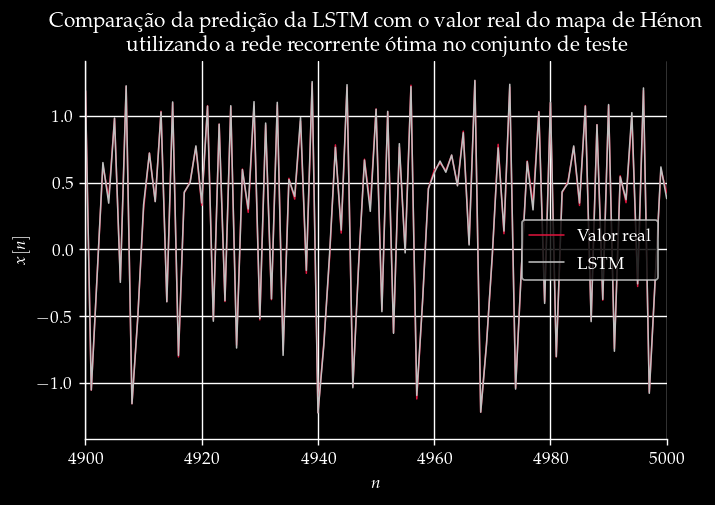

In [26]:
fig, ax = plt.subplots()
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_teste, color='Crimson', label='Valor real', linewidth=0.9)
ax.plot(n[len(n)-int(len(n)*tam_teste):,], y_pred, color='Silver', label='LSTM', linewidth=0.9)

ax.set_title("Comparação da predição da LSTM com o valor real do mapa de Hénon\n utilizando a rede recorrente ótima no conjunto de teste")
ax.set_ylabel('$x[n]$')
ax.set_xlabel('$n$')
ax.set_xlim(4900, 5000)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()
fig.savefig("../../../images/lstm/performance/lstm-vs-henon.png")

### Erro Quadrático Médio

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
mse = mean_squared_error(y_teste, y_pred)
print("MSE = " + str(mse))

MSE = 0.0002446414576968061


### Salvando o Modelo

In [29]:
model.salvar("../../../models/lstm/lstm-henon", h5="ON")

O modelo foi salvo!
